In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
!pip install -q tensorflow==2.0.0-alpha0
import tensorflow as tf

# We'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

# Scikit-learn includes many helpful utilities
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json
from glob import glob
from PIL import Image
import pickle

### Downloading MSCOCO VQA Dataset

In [0]:
annotation_zip = tf.keras.utils.get_file('captions.zip',
                                          cache_subdir=os.path.abspath('.'),
                                          origin = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                          extract = True)
annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'

name_of_zip = 'train2014.zip'
if not os.path.exists(os.path.abspath('.') + '/' + name_of_zip):
  image_zip = tf.keras.utils.get_file(name_of_zip,
                                      cache_subdir=os.path.abspath('.'),
                                      origin = 'http://images.cocodataset.org/zips/train2014.zip',
                                      extract = True)
  PATH = os.path.dirname(image_zip)+'/train2014/'
else:

  PATH = os.path.abspath('.')+'/train2014/'

In [4]:
print(PATH)
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
! unzip -a v2_Questions_Train_mscoco.zip
!wget https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
! unzip -a v2_Annotations_Train_mscoco.zip

/content/train2014/
--2019-05-20 00:45:45--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Questions_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.111.53
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.111.53|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7239401 (6.9M) [application/zip]
Saving to: ‘v2_Questions_Train_mscoco.zip.1’

v2_Questions_Train_ 100%[===================>]   6.90M  36.2MB/s    in 0.2s    

2019-05-20 00:45:45 (36.2 MB/s) - ‘v2_Questions_Train_mscoco.zip.1’ saved [7239401/7239401]

Archive:  v2_Questions_Train_mscoco.zip
replace v2_OpenEnded_mscoco_train2014_questions.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
--2019-05-20 00:52:55--  https://s3.amazonaws.com/cvmlp/vqa/mscoco/vqa/v2_Annotations_Train_mscoco.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.144.45
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.144.45|:443... connected.
HTTP request sent, awaiting response... 20

### Processing VQA Dataset

In [0]:
import collections
import operator
# read the json file
annotation_file = 'v2_mscoco_train2014_annotations.json'
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

# storing the captions and the image name in vectors
all_answers = []
all_answers_qids = []
all_img_name_vector = []
all_accepted_answers = []
for annot in annotations['annotations']:
#     print(annot)
#     break
    ans_dic = collections.defaultdict(int)
    for each in annot['answers']:
      diffans = each['answer']
      if diffans in ans_dic:
        #print(each['answer_confidence'])
        if each['answer_confidence']=='yes':
          ans_dic[diffans]+=4
        if each['answer_confidence']=='maybe':
          ans_dic[diffans]+= 2
        if each['answer_confidence']=='no':
          ans_dic[diffans]+= 1
      else:
        if each['answer_confidence']=='yes':
          ans_dic[diffans]= 4
        if each['answer_confidence']=='maybe':
          ans_dic[diffans]= 2
        if each['answer_confidence']=='no':
          ans_dic[diffans]= 1
#     print(ans_dic.items()) 
#     break
    all_accepted_answers.append(['<start> '+a[0] +' <end>' for a in ans_dic.items()])
    most_fav = max(ans_dic.items(), key=operator.itemgetter(1))[0]
    #print(most_fav)
    caption = '<start> ' + most_fav + ' <end>' #each['answer']
    
    image_id = annot['image_id']
    question_id = annot['question_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector.append(full_coco_image_path)
    all_answers.append(caption)
    all_answers_qids.append(question_id)

In [7]:
len(all_answers)

443757

In [0]:
# read the json file
question_file = 'v2_OpenEnded_mscoco_train2014_questions.json'
with open(question_file, 'r') as f:
    questions = json.load(f)

# storing the captions and the image name in vectors
question_ids =[]
all_questions = []
all_img_name_vector_2 = []

for annot in questions['questions']:
    caption = '<start> ' + annot['question'] + ' <end>'
    image_id = annot['image_id']
    full_coco_image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (image_id)

    all_img_name_vector_2.append(full_coco_image_path)
    all_questions.append(caption)
    question_ids.append(annot['question_id'])


In [9]:
print(len(all_img_name_vector),len(all_answers), len(all_answers_qids))
print(all_img_name_vector[10:15],all_answers[10:15], all_answers_qids[10:15])
print(len(all_img_name_vector), len(all_questions) , len(question_ids))
print(all_img_name_vector_2[10:15],all_questions[10:15], question_ids[10:15])

443757 443757 443757
['/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393223.jpg', '/content/train2014/COCO_train2014_000000393223.jpg'] ['<start> yes <end>', '<start> yes <end>', '<start> contrail <end>', '<start> yes <end>', '<start> white and purple <end>'] [393221000, 393221001, 393221002, 393223000, 393223001]
443757 443757 443757
['/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393221.jpg', '/content/train2014/COCO_train2014_000000393223.jpg', '/content/train2014/COCO_train2014_000000393223.jpg'] ['<start> Is the sky blue? <end>', '<start> Is there snow on the mountains? <end>', '<start> What is the white streak? <end>', '<start> Is the window open? <end>', '<start> What color is the toothbrush? <end>'] [393221000, 393221001, 39

In [52]:
# shuffling the captions and image_names together
# setting a random state


train_answers, train_questions, img_name_vector,train_accepted_answers = shuffle(all_answers,all_questions,
                                          all_img_name_vector,all_accepted_answers,
                                          random_state=1)

# selecting the first 30000 captions from the shuffled set
num_examples = 1000
train_answers = train_answers[:num_examples]
train_questions = train_questions[:num_examples]
img_name_vector = img_name_vector[:num_examples]
train_accepted_answers = train_accepted_answers[:num_examples]
print(img_name_vector[0],train_questions[0],train_answers[0])

print(len(img_name_vector),len(train_questions),len(train_answers))

/content/train2014/COCO_train2014_000000573744.jpg <start> Is this a happy animal? <end> <start> yes <end>
1000 1000 1000


### Getting Image Feature vector using VGG

In [0]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    #224 x 224 for VGG 299x299 for Inception
    img = tf.image.resize(img, (224, 224))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

In [0]:
image_model = tf.keras.applications.VGG16(include_top=False,
                                                weights='imagenet',input_shape = (224,224,3))
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [55]:
print(hidden_layer.shape)

(None, 7, 7, 512)


In [0]:
# getting the unique images
encode_train = sorted(set(img_name_vector))

# feel free to change the batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[1]))
  #print(batch_features.shape)

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

### Creating Question Vectors 

In [0]:
# This will find the maximum length of any question in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [58]:
# choosing the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_questions)
train_question_seqs = tokenizer.texts_to_sequences(train_questions)

#new edit
print(tokenizer.word_index)
ques_vocab = tokenizer.word_index
#print(train_question_seqs)

{'<unk>': 1, '<start>': 2, '<end>': 3, 'the': 4, 'is': 5, 'what': 6, 'are': 7, 'this': 8, 'in': 9, 'on': 10, 'of': 11, 'a': 12, 'how': 13, 'many': 14, 'color': 15, 'there': 16, 'people': 17, 'does': 18, 'picture': 19, 'man': 20, 'to': 21, 'wearing': 22, 'these': 23, 'where': 24, 'type': 25, 'it': 26, 'do': 27, 'or': 28, 'animal': 29, 'you': 30, 'photo': 31, 'woman': 32, 'they': 33, 'person': 34, 'made': 35, 'have': 36, 'kind': 37, 'dog': 38, 'doing': 39, 'fruit': 40, 'which': 41, 'holding': 42, 'food': 43, 'for': 44, 'cat': 45, 'room': 46, 'train': 47, 'at': 48, 'his': 49, 'he': 50, 'any': 51, 'taken': 52, 'shown': 53, 'table': 54, 'see': 55, 'sign': 56, 'why': 57, 'animals': 58, 'can': 59, 'here': 60, 'boy': 61, 'playing': 62, 'vehicle': 63, "man's": 64, 'hand': 65, 'all': 66, 'shirt': 67, 'from': 68, 'that': 69, 'sitting': 70, 'clock': 71, 'an': 72, 'looking': 73, 'game': 74, 'right': 75, 'she': 76, 'water': 77, 'plate': 78, 'building': 79, 'sport': 80, 'white': 81, 'be': 82, 'guy': 

In [0]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [0]:
# creating the tokenized vectors
train_question_seqs = tokenizer.texts_to_sequences(train_questions)

In [0]:
# padding each vector to the max_length of the captions
# if the max_length parameter is not provided, pad_sequences calculates that automatically
question_vector = tf.keras.preprocessing.sequence.pad_sequences(train_question_seqs, padding='post')
#cap_vector

In [62]:
# calculating the max_length
# used to store the attention weights
max_length = calc_max_length(train_question_seqs)
print(max_length)

#new edit
max_q = max_length

19


### Creating answer vectors


In [0]:
# considering all answers to be part of ans vocab
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

# define example
data = train_answers
values = array(data)
# print(values[:10])

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(values)
#print(integer_encoded)

#new edit
ans_vocab = {l: i for i, l in enumerate(label_encoder.classes_)}
# print(ans_vocab)

answer_vector = integer_encoded

#new edit
len_ans_vocab = len(ans_vocab)

# print(answer_vector)

In [0]:
print(len(question_vector[0]), len(answer_vector))

In [0]:
possible_answers = []
for answers in train_accepted_answers:
    ans_v = []
    for answer in answers:
        try:
            ans_v.append(label_encoder.transform([answer])[0])
        except:
            a = 1
    possible_answers.append(ans_v)

In [0]:
b = (-1)*np.ones([len(possible_answers),len(max(possible_answers,key = lambda x: len(x)))])
for i,j in enumerate(possible_answers):
    b[i][0:len(j)] = j
#     print(i,j)

In [0]:
possible_answers = b

### TRAIN - TEST SPLIT

In [0]:
img_name_train, img_name_val, question_train, question_val,answer_train, answer_val,possible_train,possible_val  = train_test_split(img_name_vector,
                                                                    question_vector,
                                                                    answer_vector,np.array(possible_answers),
                                                                    test_size=0.1,
                                                                    random_state=0)


In [69]:
print(len(img_name_train), len(img_name_val), len(question_train), len(question_val),len(answer_train), len(answer_val))

900 100 900 100 900 100


### Almost done with data processing!!!

In [0]:
# feel free to change these parameters according to your system's configuration

BATCH_SIZE = 32 #2 #64
BUFFER_SIZE = 300 #1000
num_steps = len(img_name_train) // BATCH_SIZE
# shape of the vector extracted from VGG is (49, 512)
# these two variables represent that
features_shape = 512
attention_features_shape = 49


In [0]:
# loading the numpy files
def map_func(img_name, cap,ans,p_ans,im_name):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap,ans,p_ans,im_name


In [0]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, question_train.astype(np.float32), answer_train.astype(np.float32),possible_train.astype(np.float32),img_name_train))

# using map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2, item3,item4,item5: tf.numpy_function(map_func, [item1, item2, item3,item4,item5], [tf.float32, tf.float32, tf.float32,tf.float32,tf.string]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)

# shuffling and batching
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, question_val.astype(np.float32), answer_val.astype(np.float32),possible_val.astype(np.float32),img_name_val))

# using map to load the numpy files in parallel
test_dataset = test_dataset.map(lambda item1, item2, item3,item4,item5: tf.numpy_function(map_func, [item1, item2, item3,item4,item5], [tf.float32, tf.float32, tf.float32,tf.float32,tf.string]),
          num_parallel_calls=tf.data.experimental.AUTOTUNE)


# shuffling and batching
test_dataset = test_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Hierarchial Co-Attention Model

In [0]:
import numpy as np
from tensorflow import reshape
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, LSTM, Activation,ZeroPadding1D,Conv1D


In [0]:
class ParallelCoattentionModel(tf.keras.Model):
  def __init__(self,ans_vocab,max_q,ques_vocab):
    super(ParallelCoattentionModel, self).__init__(name='ParallelCoattentionModel')
    self.ans_vocab = ans_vocab
    self.max_q = max_q
    self.ques_vocab = ques_vocab
    self.ip_dense = Dense(512, activation=None, input_shape=(512,)) 
    num_words = len(ques_vocab)+2
    self.word_level_feats = Embedding(input_dim = len(ques_vocab)+2,output_dim = 512)
    self.lstm_layer = LSTM(512,return_sequences=True,input_shape=(None,max_q,512)) 
    self.dropout_layer = Dropout(0.5)
    self.tan_layer = Activation('tanh')
    self.phrase_level_unigram = Conv1D(512,kernel_size=512,strides=512) 
    self.phrase_level_bigram = Conv1D(512,kernel_size=2*512,strides=512,padding='same') 
    self.phrase_level_trigram = Conv1D(512,kernel_size=3*512,strides=512,padding='same') 
    self.basic_dense_layer = Dense(512, activation=None, input_shape=(512,)) 
    self.dense_image = Dense(512, activation=None, input_shape=(512,))
    self.dense_text = Dense(512, activation=None, input_shape=(512,))
    self.image_attention = Dense(1, activation='softmax', input_shape=(512,))
    self.text_attention = Dense(1, activation='softmax', input_shape=(512,)) 
    self.dense_word_level = Dense(512, activation=None, input_shape=(512,)) 
    self.dense_phrase_level = Dense(512, activation=None, input_shape=(2*512,))
    self.dense_sent_level = Dense(512, activation=None, input_shape=(2*512,)) 
    self.dense_final = Dense(len(ans_vocab), activation=None, input_shape=(512,))
    
	
  def similarity(self,image_feat,text_feat): 
    temp_C = self.basic_dense_layer(image_feat)  
    temp_C =  tf.transpose(temp_C, perm=[0,2,1]) 
    C_ = tf.matmul(text_feat, temp_C) 
    C_ = self.tan_layer(C_)
    C_ = self.dropout_layer(C_) #Refer eqt (3) section 3.3 
    V_ = self.dense_image(image_feat)
    Q_ = self.dense_text(text_feat)
    QC_ = tf.matmul(tf.transpose(Q_, perm=[0,2,1]),C_) 
    QC_ = tf.transpose(QC_, perm =[0,2,1]) 
    temp1 = V_ + QC_
    temp1 = self.tan_layer(temp1)
    H_img = self.dropout_layer(temp1) #Refer eqt (4) section 3.3 
    VC_ = tf.matmul(tf.transpose(V_, perm=[0,2,1]),tf.transpose(C_,perm=[0,2,1])) 
    VC_ = tf.transpose(VC_, perm =[0,2,1]) 
    temp2 = Q_ + VC_
    temp2 = self.tan_layer(temp2)
    H_text = self.dropout_layer(temp2)
    return H_img, H_text
  
  def parallel_attention(self,image_feat,text_feat,H_img,H_text): 
    a_img = self.image_attention(H_img)
    a_text = self.text_attention(H_text)¡
    return tf.reduce_sum(a_img * image_feat,1), tf.reduce_sum(a_text * text_feat,1) #Refer eqt (5) section 3.3

    
  def call(self,image_feat,question_encoding): 
    # Image features
    image_feat = self.ip_dense(image_feat) #check input shape (512,) ???
    
    # Text fetaures 
    
    # Text: Word level
    word_feat = self.word_level_feats(question_encoding) 
    
    # Text: Phrase level
    word_feat_ = tf.reshape(word_feat,[word_feat.shape[0], 1, -1])
    word_feat_= tf.transpose(word_feat_, perm=[0,2,1]) 
    uni_feat = self.phrase_level_unigram(word_feat_)
    uni_feat = tf.expand_dims(uni_feat,-1) 
    bi_feat = self.phrase_level_bigram(word_feat_) 
    bi_feat = tf.expand_dims(bi_feat,-1)
    tri_feat = self.phrase_level_trigram(word_feat_)
    tri_feat = tf.expand_dims(tri_feat,-1)
    all_feat = tf.concat([uni_feat, bi_feat, tri_feat],-1)
    phrase_feat = tf.reduce_max(all_feat,-1) 
    
    # Text: Sentence level
    sent_feat = self.lstm_layer(phrase_feat) #temp1 #old lstm_
    
    #Applying attention
    # All variable names correspond to Fig.3(b)in paper. 
    
    # Attention on word level features
    w_H_img,w_H_text = self.similarity(image_feat,word_feat)
    v_w,q_w = self.parallel_attention(image_feat,word_feat,w_H_img,w_H_text)
    h_w = v_w + q_w
    h_w_ = self.dropout_layer(self.tan_layer(self.dense_word_level(h_w)))
    
    # Attention on phrase level features
    p_H_img,p_H_text = self.similarity(image_feat,phrase_feat)
    v_p,q_p = self.parallel_attention(image_feat,phrase_feat,p_H_img,p_H_text)
    h_p = tf.concat([v_p + q_p, h_w_],-1) 
    h_p_ = self.dropout_layer(self.tan_layer(self.dense_phrase_level(h_p)))
    
    # Attention on sentence level features
    s_H_img,s_H_text = self.similarity(image_feat,sent_feat)
    v_s,q_s = self.parallel_attention(image_feat,sent_feat,s_H_img,s_H_text)
    h_s = tf.concat([v_s + q_s, h_p_],-1) 
    h_s_ = self.dropout_layer(self.tan_layer(self.dense_sent_level(h_s)))

    return self.dense_final(h_s_)


In [0]:
model = ParallelCoattentionModel(ans_vocab,max_q,ques_vocab)

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False) #Sparse
optimizer = tf.keras.optimizers.Adam()
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

train_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
test_accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [0]:
def train_step(images, questions, answers ,model):
  with tf.GradientTape() as tape:    
    # Forward pass
    predictions = model(images, questions)
    train_loss = loss_function(y_true=answers, y_pred=predictions)
  
  # Backward pass
  gradients = tape.gradient(train_loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

  # Record results
  train_loss_metric(train_loss)
  train_accuracy_metric(answers, predictions)

In [0]:
def test_step(images,questions, answers,model):
  predictions = model(images,questions)
  test_loss = loss_function(y_true=answers, y_pred=predictions)
  
  # Record results
  test_loss_metric(test_loss)
  test_accuracy_metric(answers, predictions)

In [0]:
EPOCHS = 30
train_loss =[]
test_loss=[]
train_acc=[]
test_acc=[]
for epoch in range(EPOCHS):
  for (batch, (img_tensor, question, answer,p_answers,image_names)) in enumerate(dataset):
  #for images, labels in vqa_train:
    train_step(img_tensor, question, answer ,model)
  
  #for test_images, test_labels in vqa_test:
  for (batch, (img_tensor, question, answer,p_answers,image_names)) in enumerate(test_dataset):
    test_step(img_tensor, question, answer,model)
  
  template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Test loss: {:.4f}, Test accuracy: {:.2f}'
  train_loss.append(train_loss_metric.result())
  test_loss.append(test_loss_metric.result())
  train_acc.append(train_accuracy_metric.result() * 100)
  test_acc.append(test_accuracy_metric.result() * 100)
  print (template.format(epoch +1, 
                         train_loss_metric.result(), 
                         train_accuracy_metric.result() * 100, 
                         test_loss_metric.result(), 
                         test_accuracy_metric.result() * 100))

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding, LSTM, Activation,ZeroPadding1D,Conv1D

class AlternatingCoattentionModel(tf.keras.Model):
  def __init__(self,ans_vocab,max_q,ques_vocab):
    super(AlternatingCoattentionModel, self).__init__(name='AlternatingCoattentionModel')
    self.ans_vocab = ans_vocab
    self.max_q = max_q
    self.ques_vocab = ques_vocab
    
    
    self.ip_dense = Dense(256, activation=None, input_shape=(512,)) 
    num_words = len(ques_vocab)+2
    self.word_level_feats = Embedding(input_dim = len(ques_vocab)+2,output_dim = 256)
    self.lstm_layer = LSTM(256,return_sequences=True,input_shape=(None,max_q,256)) 
    self.dropout_layer = Dropout(0.5)
    self.tan_layer = Activation('tanh')
    self.phrase_level_unigram = Conv1D(256,kernel_size=256,strides=256) 
    self.phrase_level_bigram = Conv1D(256,kernel_size=2*256,strides=256,padding='same') 
    self.phrase_level_trigram = Conv1D(256,kernel_size=3*256,strides=256,padding='same') 
    self.dense_image = Dense(256, activation=None, input_shape=(256,))
    self.dense_text = Dense(256, activation=None, input_shape=(256,))
    self.image_attention = Dense(1, activation='softmax', input_shape=(256,))
    self.text_attention = Dense(1, activation='softmax', input_shape=(256,)) 
    self.dense_word_level = Dense(256, activation=None, input_shape=(256,)) 
    self.dense_phrase_level = Dense(256, activation=None, input_shape=(2*256,)) 
    self.dense_sent_level = Dense(256, activation=None, input_shape=(2*256,)) 
    self.dense_final = Dense(len(ans_vocab), activation=None, input_shape=(256,))
    
    
  def similarity(self,image_feat,text_feat,g,prev_att):
    V_ = self.dense_image(image_feat)
    Q_ = self.dense_text(text_feat)
    
    if g==0:
      temp1 = self.tan_layer(Q_)
      H_text = self.dropout_layer(temp1) 
      return H_text
    
    elif g==1:
      g = self.dense_text(prev_att)   
      g = tf.expand_dims(g,1)
      temp = V_ + g
      temp = self.tan_layer(temp)
      H_img = self.dropout_layer(temp)
      return H_img
      
    elif g==2:
      g = self.dense_image(prev_att)
      g = tf.expand_dims(g,1)
      temp = Q_ + g
      temp = self.tan_layer(temp)
      H_text = self.dropout_layer(temp)
      return H_text
    
  
  def attention_ques(self,text_feat,H_text):
    temp = self.text_attention(H_text)
    return tf.reduce_sum(temp * text_feat,1) 
  
  
  def attention_img(self,image_feat,H_img):
    temp = self.image_attention(H_img)
    return tf.reduce_sum(temp * image_feat,1)
    
  def call(self,image_feat,question_encoding):
    # Processing the image
    image_feat = self.ip_dense(image_feat) 

    # Text fetaures 

    # Text: Word level
    word_feat = self.word_level_feats(question_encoding) 

    # Text: Phrase level
    word_feat_ = tf.reshape(word_feat,[word_feat.shape[0], 1, -1])
    word_feat_= tf.transpose(word_feat_, perm=[0,2,1]) 
    uni_feat = self.phrase_level_unigram(word_feat_)
    uni_feat = tf.expand_dims(uni_feat,-1) 
    bi_feat = self.phrase_level_bigram(word_feat_) 
    bi_feat = tf.expand_dims(bi_feat,-1)
    tri_feat = self.phrase_level_trigram(word_feat_)
    tri_feat = tf.expand_dims(tri_feat,-1)
    all_feat = tf.concat([uni_feat, bi_feat, tri_feat],-1)
    phrase_feat = tf.reduce_max(all_feat,-1) 

    # Text: Sentence level
    sent_feat = self.lstm_layer(phrase_feat) 

  	#Apply attention to features at all three levels

    # Applying attention on word level features
    word_H_text = self.similarity(image_feat,word_feat,0,0)
    word_text_attention = self.attention_ques(word_feat,word_H_text)
    word_H_img = self.similarity(image_feat,word_feat,1,word_text_attention)
    word_img_attention = self.attention_img(image_feat,word_H_img)
    word_H_text = self.similarity(image_feat,word_feat,2,word_img_attention)
    word_text_attention = self.attention_ques(word_feat,word_H_text)

    word_level_attention = word_img_attention + word_text_attention
    word_pred = self.dropout_layer(self.tan_layer(self.dense_word_level(word_level_attention)))

    # Applying attention on phrase level features
    phrase_H_text = self.similarity(image_feat,phrase_feat,0,0)
    phrase_text_attention = self.attention_ques(phrase_feat,phrase_H_text)
    phrase_H_img = self.similarity(image_feat,phrase_feat,1,phrase_text_attention)
    phrase_img_attention = self.attention_img(image_feat,phrase_H_img)
    phrase_H_text = self.similarity(image_feat,phrase_feat,2,phrase_img_attention)
    phrase_text_attention = self.attention_ques(phrase_feat,phrase_H_text)

    phrase_level_attention = tf.concat([phrase_img_attention + phrase_text_attention, word_pred],-1) 
    phrase_pred = self.dropout_layer(self.tan_layer(self.dense_phrase_level(phrase_level_attention)))

    # Applying attention on sentence level features
    sent_H_text = self.similarity(image_feat,sent_feat,0,0)
    sent_text_attention = self.attention_ques(sent_feat,sent_H_text)
    sent_H_img = self.similarity(image_feat,sent_feat,1,sent_text_attention)
    sent_img_attention = self.attention_img(image_feat,sent_H_img)
    sent_H_text = self.similarity(image_feat,sent_feat,2,sent_img_attention)
    sent_text_attention = self.attention_ques(sent_feat,sent_H_text)

    sentence_level_attention = tf.concat([sent_img_attention + sent_text_attention, phrase_pred],-1) 
    sent_pred = self.dropout_layer(self.tan_layer(self.dense_sent_level(sentence_level_attention)))


    return self.dense_final(sent_pred)


In [0]:
model =AlternatingCoattentionModel(ans_vocab,max_q,ques_vocab)

In [0]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
train_loss_metric = tf.keras.metrics.Mean(name='train_loss')
test_loss_metric = tf.keras.metrics.Mean(name='test_loss')

train_accuracy_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 1,name = "train_accuracy")
test_accuracy_metric = tf.keras.metrics.SparseTopKCategoricalAccuracy(k = 1,name = "test_accuracy")

In [0]:
crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

def calc_loss(targets, logits):
  return crossentropy(targets, logits)


In [0]:
# @tf.function # remove this annotation when debugging
def train_step(input_image, input_question, target_labels,p_answers):
  with tf.GradientTape() as tape:
    logits = model(input_image,input_question)
    loss = calc_loss(target_labels, logits)

  variables = model.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  train_loss_metric(loss)
  train_accuracy_metric(target_labels, logits)

In [0]:
def test_step(images,questions, answers,model,p_answers):
  predictions = model(images,questions)
  test_loss = calc_loss(answers, predictions)
  
  # Record results
  test_loss_metric(test_loss)
  test_accuracy_metric(answers, predictions)

In [93]:
EPOCHS = 10

for epoch in range(EPOCHS+1):
    start = time.time()
  
    
    for (batch,(image_tensor,question,answer,p_answers,image_names)) in enumerate(dataset):
#         print(image_tensor.shape)
#         print(question)
#         print(answer)
#         break
        loss = train_step(image_tensor,question,answer,p_answers)
        elapsed = time.time() - start
#     break
    for (batch, (img_tensor, question, answer,p_answers,image_names)) in enumerate(test_dataset):
        test_step(img_tensor, question, answer,model,p_answers)
    if epoch % 1 == 0:
        template = 'Epoch {}, Loss: {:.4f}, Accuracy: {:.2f}, Test loss: {:.4f}, Test accuracy: {:.2f}'
        print (template.format(epoch +1, 
                         train_loss_metric.result(), 
                         train_accuracy_metric.result() * 100, 
                         test_loss_metric.result(), 
                         test_accuracy_metric.result() * 100))
#       input_sent, target_sent, translation = translate()
#       print("Input: %s\nTarget: %s\nTranslation: %s\n" % (input_sent, target_sent, translation))




Epoch 1, Loss: 5.7278, Accuracy: 15.73, Test loss: 5.7369, Test accuracy: 14.84
Epoch 2, Loss: 5.7236, Accuracy: 16.16, Test loss: 5.7369, Test accuracy: 14.84
Epoch 3, Loss: 5.7222, Accuracy: 16.31, Test loss: 5.7369, Test accuracy: 14.84
Epoch 4, Loss: 5.7215, Accuracy: 16.38, Test loss: 5.7369, Test accuracy: 14.84
Epoch 5, Loss: 5.7211, Accuracy: 16.42, Test loss: 5.7369, Test accuracy: 14.84
Epoch 6, Loss: 5.7208, Accuracy: 16.45, Test loss: 5.7369, Test accuracy: 14.84
Epoch 7, Loss: 5.7206, Accuracy: 16.47, Test loss: 5.7369, Test accuracy: 14.84
Epoch 8, Loss: 5.7204, Accuracy: 16.49, Test loss: 5.7369, Test accuracy: 14.84
Epoch 9, Loss: 5.7203, Accuracy: 16.50, Test loss: 5.7369, Test accuracy: 14.84
Epoch 10, Loss: 5.7202, Accuracy: 16.51, Test loss: 5.7369, Test accuracy: 14.84
Epoch 11, Loss: 5.7202, Accuracy: 16.52, Test loss: 5.7369, Test accuracy: 14.84


In [0]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [0]:
def test_vqa(num = 10):
    ctr = 0    
    for (batch, (img_tensor, question, answer,p_answers,img_name)) in enumerate(test_dataset):
            
            p = model(img_tensor,question)
            p = tf.math.top_k(p,k=2)
            p_indices = p.indices.numpy()
            questions = question.numpy()
            t_image_names = img_name.numpy()
            p_answers = p_answers.numpy()
            for i in range(len(t_image_names)):
                image = mpimg.imread(t_image_names[i].decode('utf-8'))
                plt.imshow(image)
                plt.show()
                print("Question: ",tokenizer.sequences_to_texts([questions[i]]))
                print("Predicted answers: ",label_encoder.inverse_transform(p_indices[i]))
                poss = p_answers[i]
                poss = poss[poss>=0]
                print("Correct answers:")
                for opt in poss:
                    print(label_encoder.inverse_transform([int(opt)]))
                ctr += 1
                if ctr==10:
                    break
            if ctr == 10:
                break
    #         print(label_encoder.inverse_transform(p_answers[np.argwhere(p_answers>=0)]))
            break

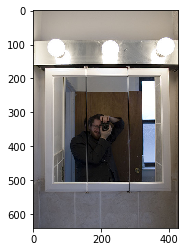

Question:  ['<start> where is this picture taken <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> bathroom <end>']


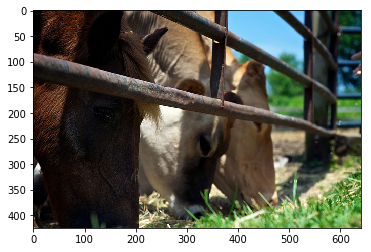

Question:  ['<start> is the grass green <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> yes <end>']


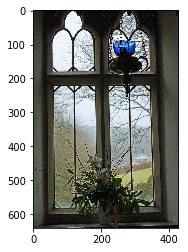

Question:  ['<start> is the sky cloudy <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> yes <end>']


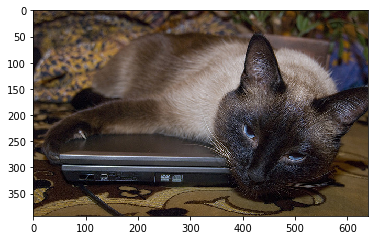

Question:  ['<start> what is the cat lying on <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> laptop <end>']


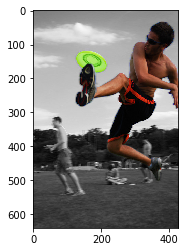

Question:  ['<start> is this man kicking a neon frisbee <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> no <end>']
['<start> yes <end>']


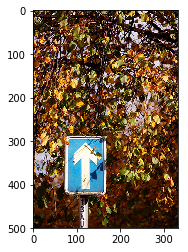

Question:  ['<start> what color is this sign <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> blue <end>']


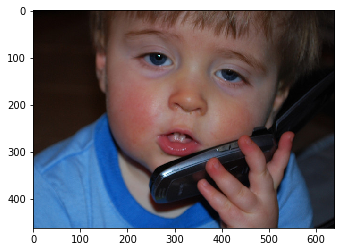

Question:  ['<start> is the kid talking on the phone <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> yes <end>']


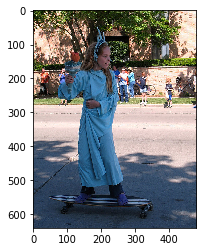

Question:  ['<start> how many people are wearing blue <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> 2 <end>']
['<start> 5 <end>']
['<start> 8 <end>']
['<start> 3 <end>']
['<start> 4 <end>']
['<start> 7 <end>']
['<start> 1 <end>']
['<start> 6 <end>']


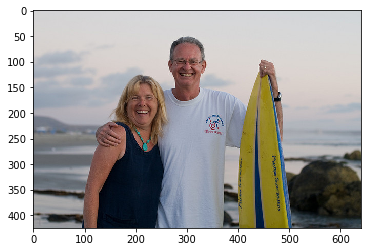

Question:  ['<start> on which body part is his hand resting <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> shoulder <end>']


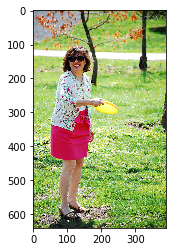

Question:  ['<start> what is the woman holding in her hand <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>']
Predicted answers:  ['<start> yes <end>' '<start> 0 <end>']
Correct answers:
['<start> frisbee <end>']


In [96]:
test_vqa(num = 5)